In [95]:
from dotenv import load_dotenv
load_dotenv()

True

In [96]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2")

In [97]:
llm.invoke("hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-18T00:22:25.0223552Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 319397900, 'load_duration': 25578100, 'prompt_eval_count': 26, 'prompt_eval_duration': 79011000, 'eval_count': 10, 'eval_duration': 213549000}, id='run-a63271d4-7c4f-40bf-88e0-f64ffba137be-0', usage_metadata={'input_tokens': 26, 'output_tokens': 10, 'total_tokens': 36})

In [98]:
# State

from langgraph.graph import MessagesState
from typing_extensions import Annotated

def increment_num_track(orig, new):
  
  if orig == None or orig == 0: 
    return 1
  return orig + 1

class CustomState(MessagesState):
  num_track: Annotated[int, increment_num_track]
  pass
  

In [99]:
# Tools
from langchain_core.tools import tool

class Book:
  def __init__(self, title, author, description=""):
    self.title = title
    self.author = author
    self.description = description
    self.ratings = 0
  
  def add_description(self, description):
    self.description = description
    
  def add_review_ratings(self, ratings: int):
    self.ratings = ratings

@tool(return_direct=True)
def create_book(title: str, author: str):
  """When given a title and author create a Book Object

  Args:
      title: title of the book
      author: author of the book
  """
  book = Book(title, author)
  return "this is my custom message. Let's see if this will be placed anywhere"

def add_book_description(book: Book, description: str):
  """When given a book and the description, add description to the book

  Args:
      book: Book object
      description: description of the book
  """
  book.add_description(description)
  return book

def add_book_ratings(book: Book, ratings: int):
  """When given a book and the review ratings, add the ratings to the book

  Args:
      book: Book object
      ratings: ratings of the book
  """
  book.add_review_ratings(ratings)
  return book 

tools = [create_book]
llm_with_tools = llm.bind_tools(tools)

In [100]:
# Node
import copy
def book_creating_llm(state):
  new_state = copy.deepcopy(state)
  new_state["messages"]  = llm_with_tools.invoke(state["messages"])
  return new_state

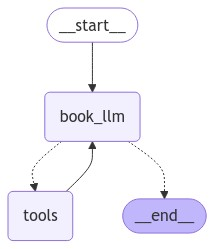

In [101]:
# builder
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(CustomState)
builder.add_node("book_llm", book_creating_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "book_llm")
builder.add_conditional_edges("book_llm", tools_condition)
builder.add_edge("tools", "book_llm")

graph = builder.compile()

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [102]:
from langchain_core.messages import HumanMessage

state = {
  "messages": [HumanMessage(content="Create a book with title 'Thinking Fast and Slow' by the author 'Daniel Kahneman'")]
}

res = graph.invoke(state)

In [103]:
for m in res['messages']:
  m.pretty_print()
  
# print(res)

================================ Human Message =================================

Create a book with title 'Thinking Fast and Slow' by the author 'Daniel Kahneman'
================================== Ai Message ==================================
Tool Calls:
  create_book (1415a4e8-4a2a-4307-9bae-82aa2aa8ba13)
 Call ID: 1415a4e8-4a2a-4307-9bae-82aa2aa8ba13
  Args:
    author: Daniel Kahneman
    title: Thinking Fast and Slow
================================= Tool Message =================================
Name: create_book

this is my custom message. Let's see if this will be placed anywhere
================================== Ai Message ==================================

Here is a book with the title 'Thinking Fast and Slow' by the author 'Daniel Kahneman':

**Thinking Fast and Slow**

by Daniel Kahneman

This Pulitzer Prize-winning book explores how our brains make decisions, revealing that we are often irrational and prone to cognitive biases. Kahneman presents two systems of thinking: